In [213]:
%matplotlib inline

In [3]:
import numpy as np
import qiskit

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer, BasicAer

from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_city, plot_state_hinton

from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, Operator
from qiskit.circuit.library import U3Gate

from qiskit_textbook.tools import random_state, array_to_latex

# System version and misc

In [352]:
print(qiskit.__version__)

0.14.2


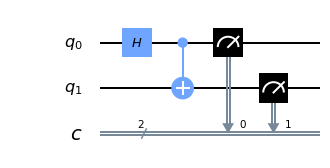

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];



In [136]:
qasmstr = '''OPENQASM 2.0; include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
cx q[0],q[1];
measure q -> c;'''

qc = QuantumCircuit.from_qasm_str(qasmstr)
display(qc.draw('mpl'))
print(qc.qasm())

# Job status

In [50]:
from qiskit import IBMQ
IBMQ.load_account()
print(IBMQ.providers())

ibmqfactory.load_account:WARNING:2021-12-11 16:42:40,815: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>]


In [52]:
provider = IBMQ.get_provider(hub='ibm-q')
print(provider, '\n')
print(provider.backends, '\n')

dev = provider.backends(filters=lambda x: x.configuration().n_qubits >= 5
                                and not x.configuration().simulator
                                and x.status().operational==True)
print(least_busy(dev))

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')> 

IBMQBackendService(_provider=<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_armonk=<IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_belem=<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_bogota=<IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_lima=<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_manila=<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_qasm_simulator=<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_quito=<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, ibmq_santiago=<IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, simulator_extended_stabilizer=<IBMQSimulator('simulato

In [175]:
backend = provider.backends.ibmq_manila
backend = least_busy(dev)

from qiskit.test.mock import FakeOpenPulse2Q,FakeMelbourne,FakeTokyo

from qiskit.test.mock import FakeVigo,FakeRueschlikon,FakePoughkeepsie,FakeTenerife
fakebackend = [FakeVigo(),FakeRueschlikon(),FakePoughkeepsie(),FakeTenerife()]

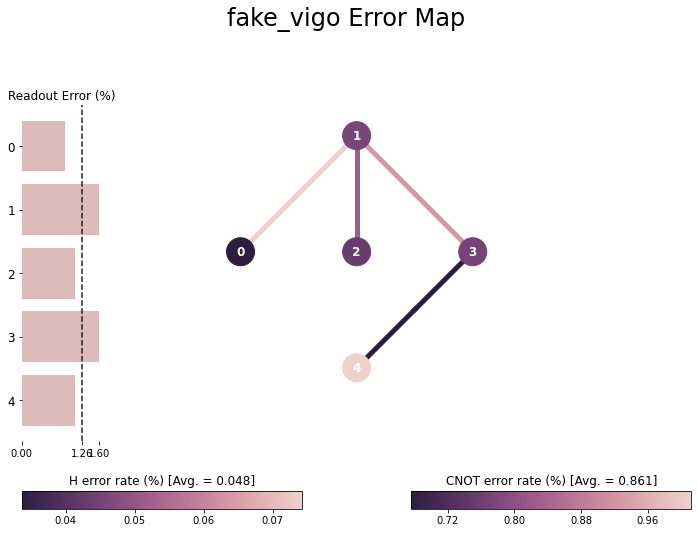

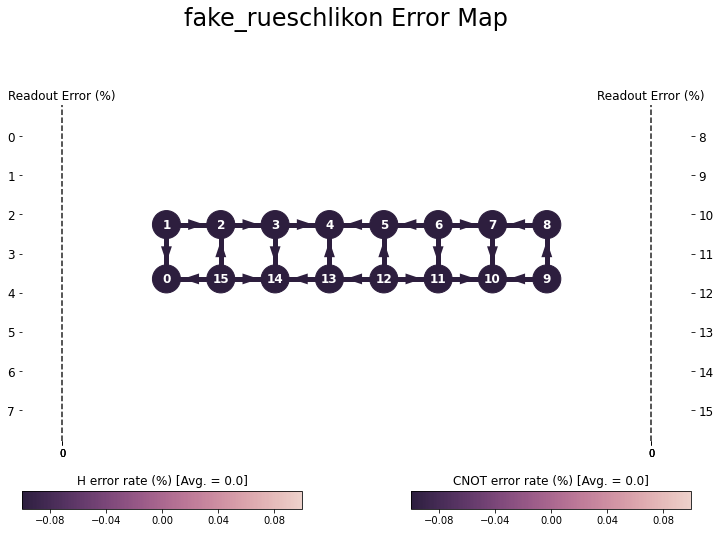

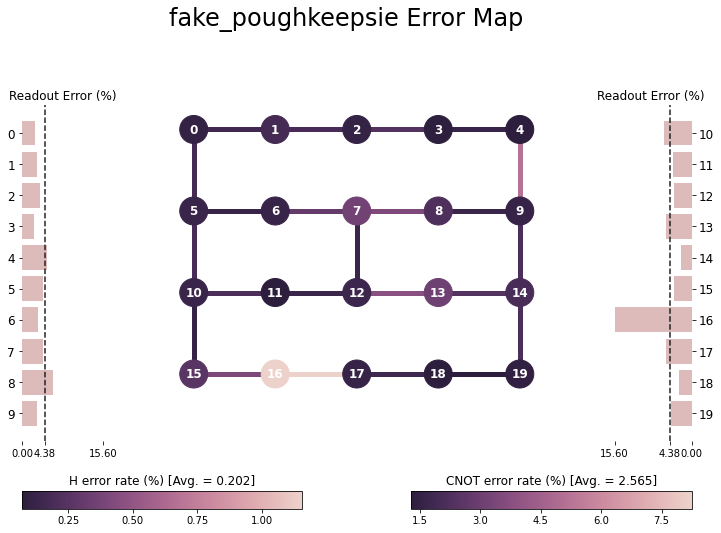

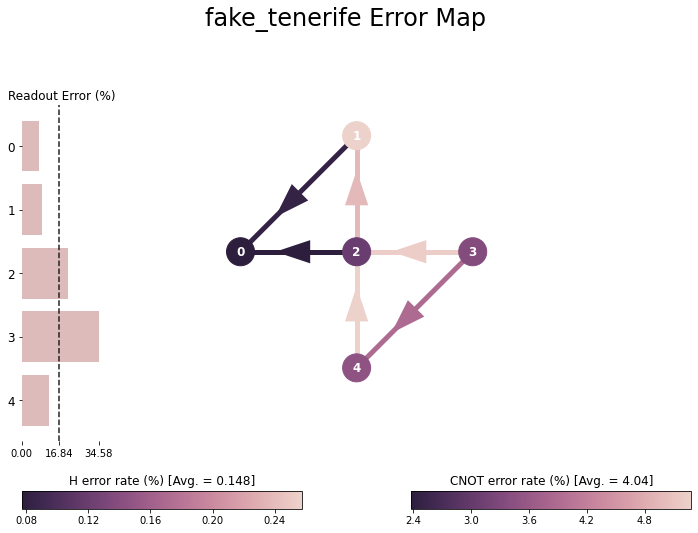

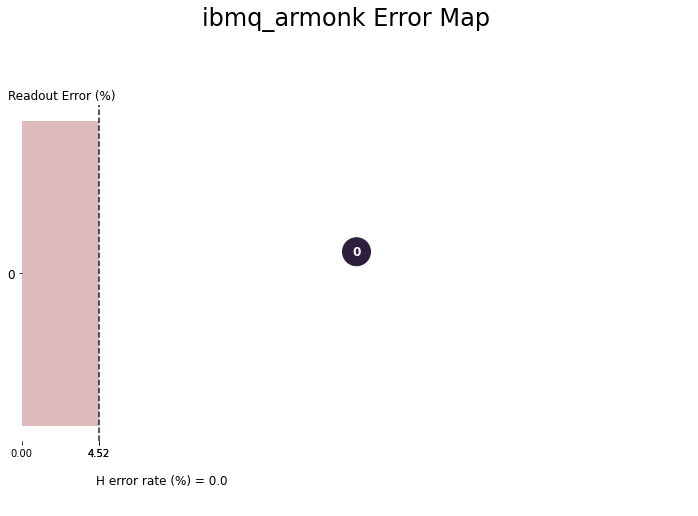

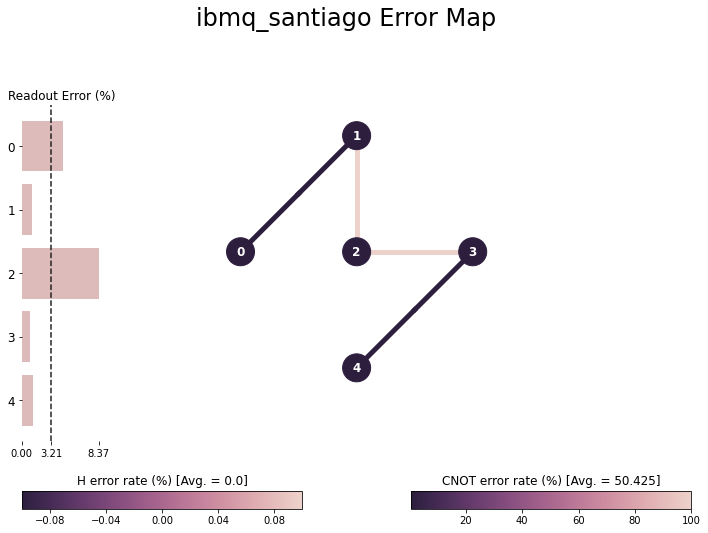

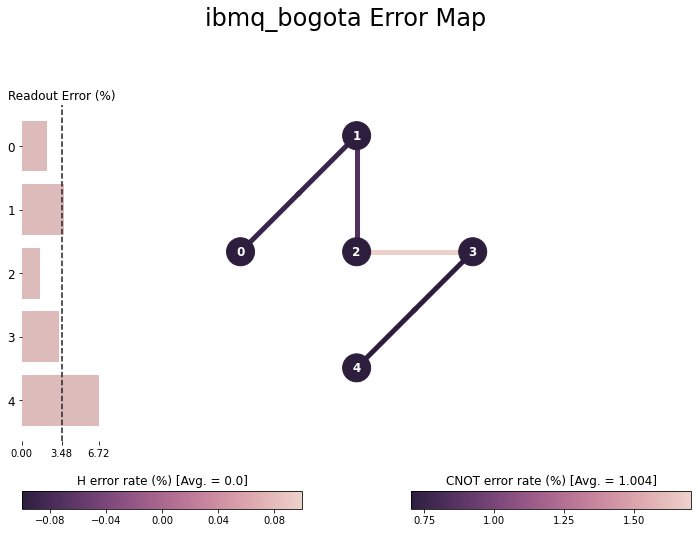

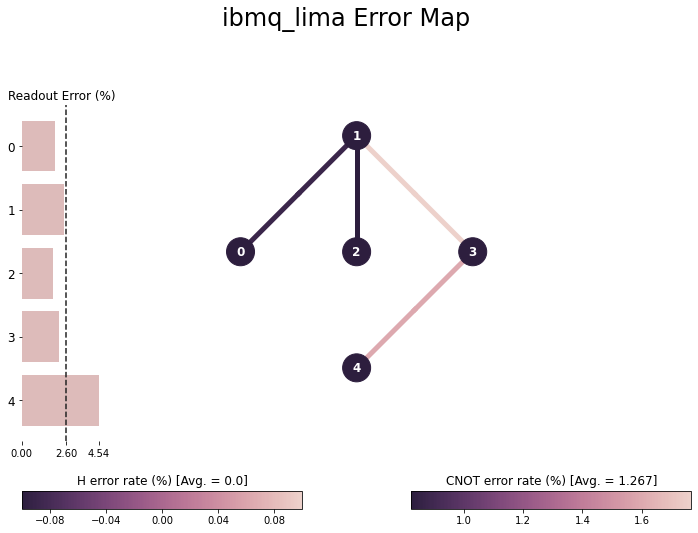

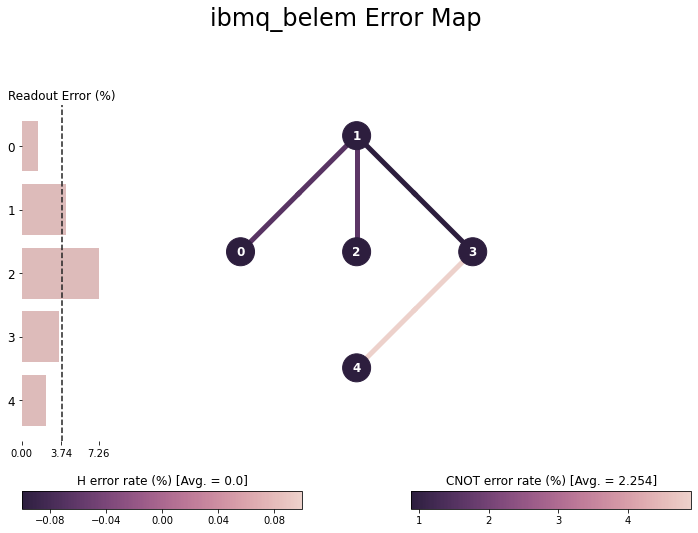

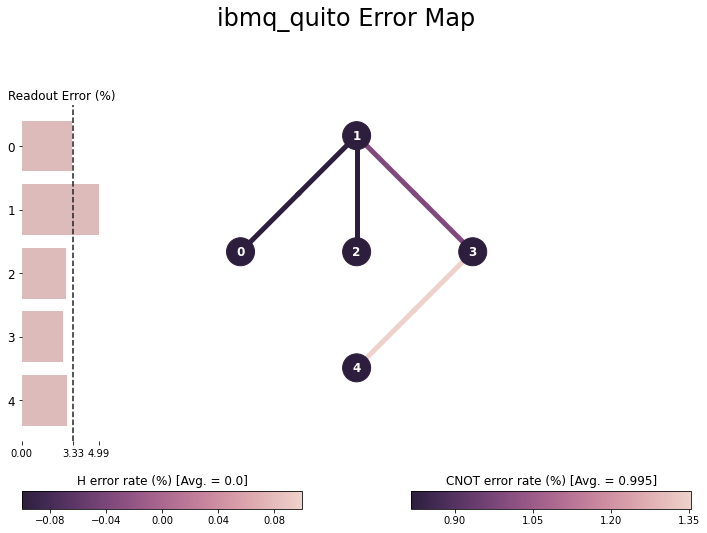

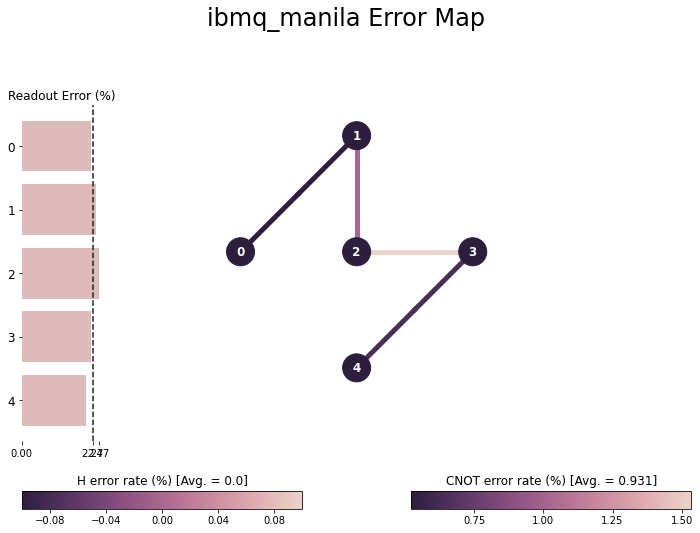

In [176]:
from qiskit.visualization import plot_error_map
for i in  fakebackend + provider.backends(filters=lambda x: not x.configuration().simulator):
    display(plot_error_map(i))

In [111]:
backend = provider.backends.ibmq_manila
filter = {'hubInfo.hub.name': 'ibm-q'}
print(backend.jobs(limit=5, db_filter=filter))

is_operational = backend.status().operational
jobs_in_queue = backend.status().pending_jobs
job_limit = backend.job_limit()

is_operational, jobs_in_queue, job_limit

[]


(True, 20, BackendJobLimit(active_jobs=0, maximum_jobs=5))

In [183]:
BasicAer.backends()

[<QasmSimulatorPy('qasm_simulator') from BasicAer()>,
 <StatevectorSimulatorPy('statevector_simulator') from BasicAer()>,
 <UnitarySimulatorPy('unitary_simulator') from BasicAer()>]

# Vector visualization and mathematical tools

In [10]:
from qiskit.quantum_info import DensityMatrix

m1 = [
    [1+0.j, 0+0.j],
    [0+0.j, 0+0.j],
]

m2 = [
    [0.5+0.j, 0.5+0.j],
    [0.5+0.j, 0.5+0.j],
]


m1 = DensityMatrix(m1)
print(m1.tensor(m2))

DensityMatrix([[0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j]],
              dims=(2, 2))


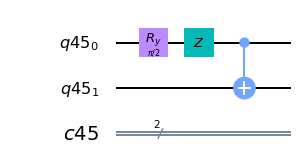

{'11': 531, '00': 493}


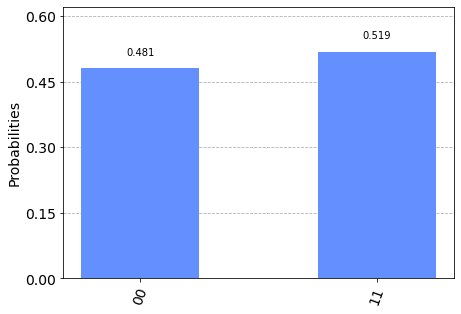

[ 0.70710678+0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j -0.70710678+8.65956056e-17j]


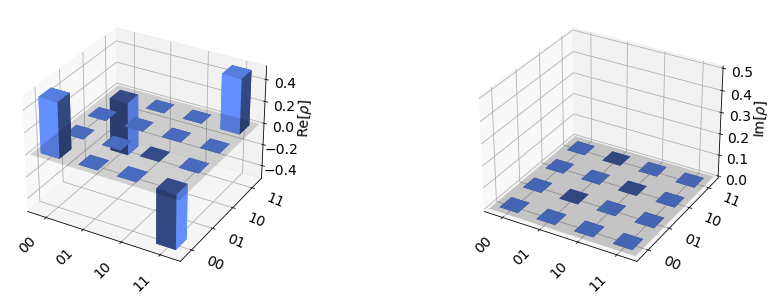

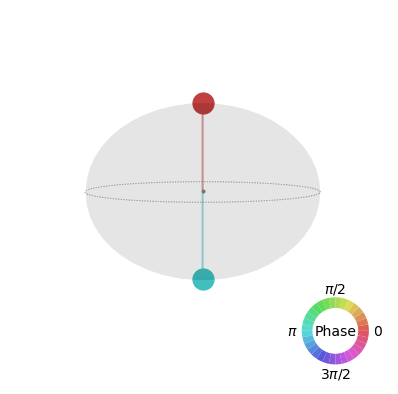

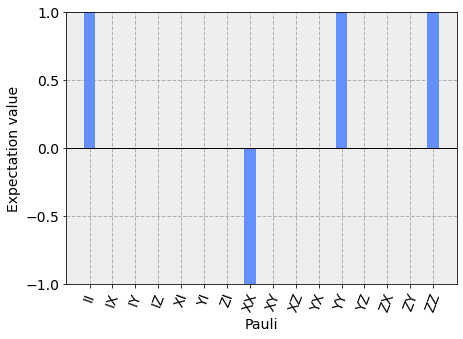

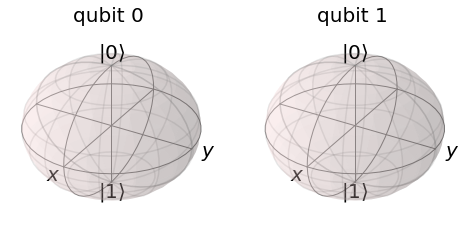

In [333]:
nbit = 2
q = QuantumRegister(nbit)
c = ClassicalRegister(nbit)

# quantum circuit to make a Bell state
qc = QuantumCircuit(q,c)
# qc.sdg(0)
# qc.h(0)
# qc.s(0)
# qc.h(0)
qc.ry(np.pi/2,0)
qc.z(0)

qc.cx(0,1)
display(qc.draw(output = 'mpl'))

meas = QuantumCircuit(q,c)
meas.measure(q, c)
# meas.measure_all()) # this cmd adds extra barrier

backend = BasicAer.get_backend('qasm_simulator') # the device to run on
circ = qc+meas
result = execute(circ, backend, shots=1024).result()
counts  = result.get_counts(circ)
print(counts)
display(plot_histogram(counts))

backend = BasicAer.get_backend('statevector_simulator')
sv = execute(qc, backend).result().get_statevector()

print(sv)

display(plot_state_city(sv))
display(plot_state_qsphere(sv))
display(plot_state_paulivec(sv))
display(plot_bloch_multivector(sv))

# plot_state_hinton(sv)
# display(plot_bloch_vector(sv))

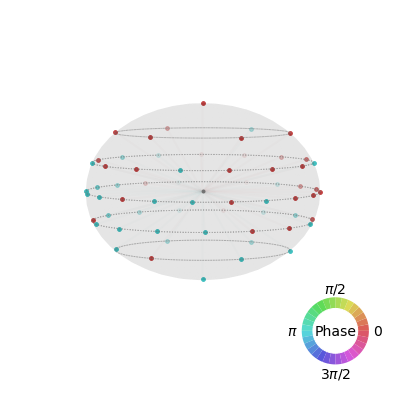

array([ 0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085e-17j,
        0.125+0.0000000e+00j, -0.125+1.5308085

In [347]:
nbit = 6
qc = QuantumCircuit(nbit,nbit)
qc.x(0)
qc.h(range(nbit))
sv = Statevector.from_instruction(qc)
display(plot_state_qsphere(sv.data))

backend = BasicAer.get_backend('statevector_simulator')
sv = execute(qc, backend).result().get_statevector()
sv

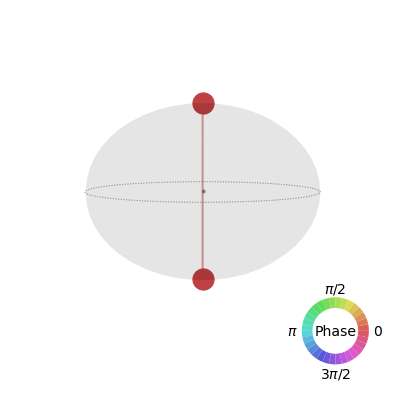

In [274]:
mysv = Statevector.from_instruction(qc)
display(plot_state_qsphere(mysv.data))

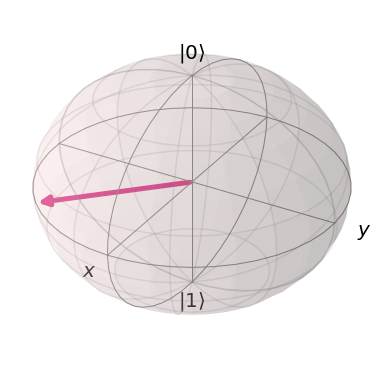

In [282]:
plot_bloch_vector([1/np.sqrt(2),-1/np.sqrt(2),0])

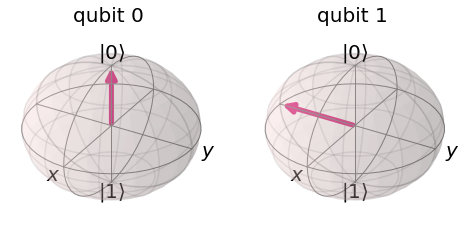

In [319]:
# 00 10 01 11

plot_bloch_multivector([0.5,-0.5,0.5,-0.5])
plot_bloch_multivector([1/np.sqrt(2),0,-1/np.sqrt(2)*1.0j,0])
# plot_bloch_multivector([1,0,0,0])

# QuantumCircuit

** below commands apply to qubit #0

| Method  | Description |
| ------------- | ------------- |
| .x(0)  | Rotates state around x-axis by $\pi$ |
| .y(0)  | Rotates state around y-axis by $\pi$ |
| .z(0)  | Rotates state around z-axis by $\pi$ |
| .h(0)  | Switches z and x values by flipping<br> around axis between $\vert0\rangle$ and x  |
| .s(0)  | Rotates state around z-axis by $\pi/2$;<br> Switches x and y values  |
| .rx($\theta$,0)  | Rotates $\theta$ radians around the x-axis.  |
| .ry($\theta$,0)  | Rotates $\theta$ radians around the y-axis.  |
| .rz($\theta$,0)  | Rotates $\theta$ radians around the z-axis.  |

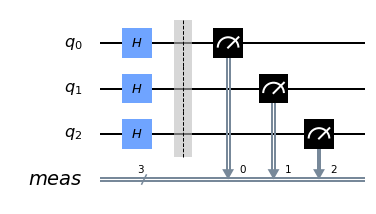

BACKEND: <qiskit.providers.models.backendstatus.BackendStatus object at 0x0000029C52BB2470> 

JOB_STATUS: JobStatus.INITIALIZING 

RESULT: Result(backend_name='qasm_simulator', backend_version='2.0.0', header=Obj(backend_name='qasm_simulator', backend_version='2.0.0'), job_id='cf7545da-4bc1-435f-a85e-3a3de6b2bf24', qobj_id='d18fae74-5d7c-4934-9745-49c706dd31ff', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x0=120, 0x1=123, 0x2=135, 0x3=121, 0x4=134, 0x5=135, 0x6=121, 0x7=135)), header=Obj(clbit_labels=[['meas', 0], ['meas', 1], ['meas', 2]], creg_sizes=[['meas', 3]], memory_slots=3, n_qubits=3, name='circuit142', qreg_sizes=[['q', 3]], qubit_labels=[['q', 0], ['q', 1], ['q', 2]]), meas_level=<MeasLevel.CLASSIFIED: 2>, name='circuit142', seed_simulator=891037668, shots=1024, status='DONE', success=True, time_taken=0.007942914962768555)], status='COMPLETED', success=True, time_taken=0.007942914962768555) 

COUNTS: {'011': 121, '000': 120, '001': 123, '010': 135, '100':

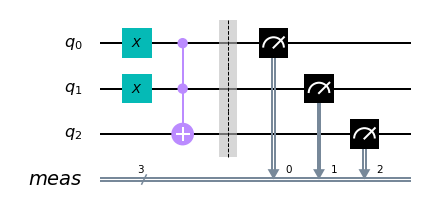

BACKEND: <qiskit.providers.models.backendstatus.BackendStatus object at 0x0000029C538D5048> 

JOB_STATUS: JobStatus.INITIALIZING 

RESULT: Result(backend_name='qasm_simulator', backend_version='2.0.0', header=Obj(backend_name='qasm_simulator', backend_version='2.0.0'), job_id='5545e6ad-67ae-4ac9-b2ef-e821cde8e701', qobj_id='785281c6-1538-4d4f-ae5c-274750102144', results=[ExperimentResult(data=ExperimentResultData(counts=Obj(0x7=1024)), header=Obj(clbit_labels=[['meas', 0], ['meas', 1], ['meas', 2]], creg_sizes=[['meas', 3]], memory_slots=3, n_qubits=3, name='circuit144', qreg_sizes=[['q', 3]], qubit_labels=[['q', 0], ['q', 1], ['q', 2]]), meas_level=<MeasLevel.CLASSIFIED: 2>, name='circuit144', seed_simulator=949893112, shots=1024, status='DONE', success=True, time_taken=0.008000373840332031)], status='COMPLETED', success=True, time_taken=0.008000373840332031) 

COUNTS: {'011': 121, '000': 120, '001': 123, '010': 135, '100': 134, '111': 135, '101': 135, '110': 121} 



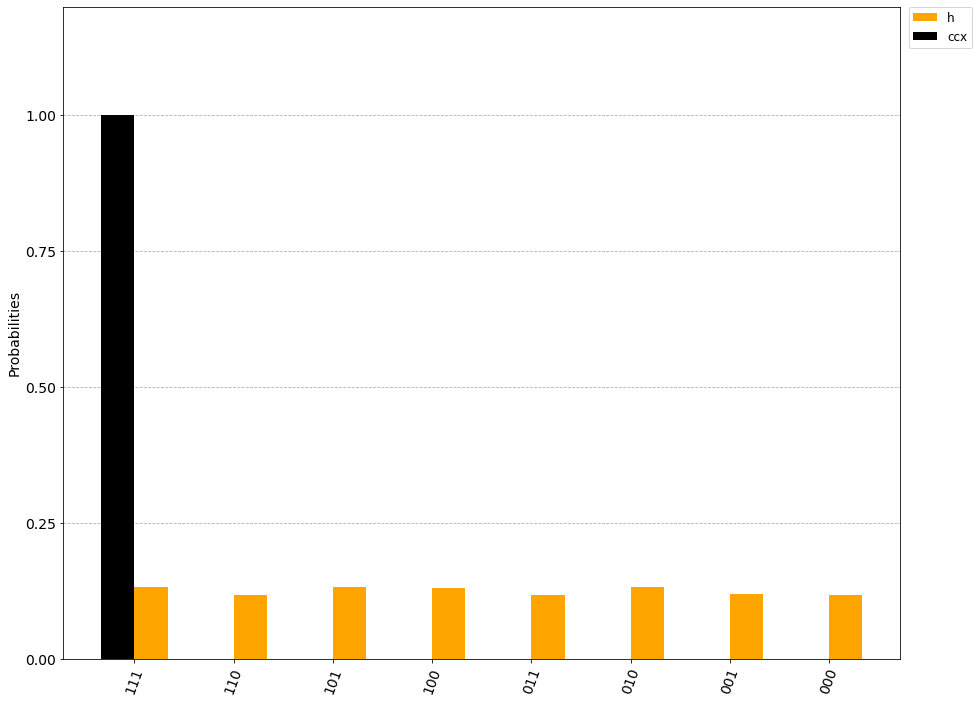

In [238]:
qc = QuantumCircuit(3)

qc.h([0,1,2])
# qc.measure([0,1,2], [0,1,2]) # Need to specify c. reg when instantiated QuantumCircuit
qc.measure_all() # this cmd adds extra barrier
display(qc.draw(output = 'mpl'))

backend = BasicAer.get_backend('qasm_simulator')
print('BACKEND:',backend.status(), '\n')

job = execute(qc, backend, shots=1024)
print('JOB_STATUS:', job.status(), '\n')

result = job.result()
print('RESULT:', result, '\n')

counts = result.get_counts()
print('COUNTS:',counts, '\n\n')

qc = QuantumCircuit(3)
qc.x([0,1])
qc.ccx(0,1,2)
# qc.measure([0,1,2], [0,1,2]) # Need to specify c. reg when instantiated QuantumCircuit
qc.measure_all() # this cmd adds extra barrier
display(qc.draw(output = 'mpl'))

backend = BasicAer.get_backend('qasm_simulator')
print('BACKEND:',backend.status(), '\n')

job = execute(qc, backend, shots=1024)
print('JOB_STATUS:', job.status(), '\n')

result = job.result()
print('RESULT:', result, '\n')

counts2 = result.get_counts()
print('COUNTS:',counts, '\n')


plot_histogram([counts,counts2],
               legend = ['h','ccx'],
               sort = 'desc',
               figsize = (15,12),
               color = ['orange', 'black'],
               bar_labels = False)

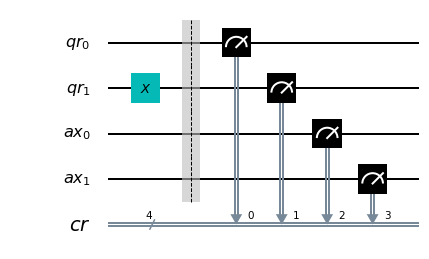

{'0010': 1024}


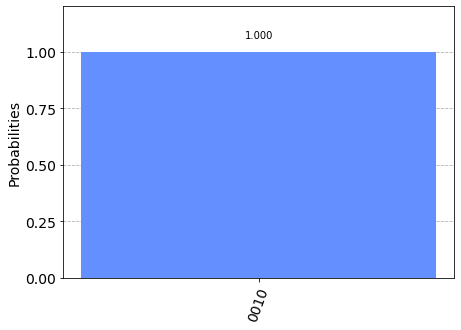

array([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

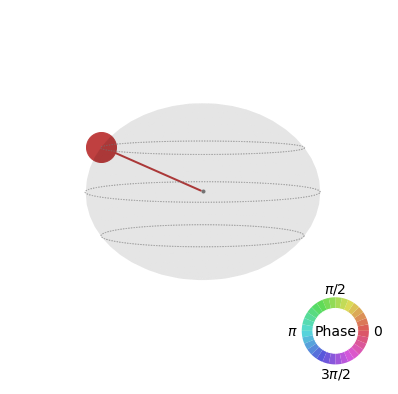

In [199]:
qr = QuantumRegister(2,'qr')
ax = QuantumRegister(2,'ax')
cr = ClassicalRegister(4,'cr')
qc = QuantumCircuit(qr,ax,cr)

#qc.initialize([0,0,0,1],[0,1])
qc.x(qr[1])
qc.barrier()
qc.measure(qr,cr[0:2])
qc.measure(ax,cr[2:4])
display(qc.draw(output = 'mpl'))

backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
print(counts)
display(plot_histogram(counts))

from qiskit.visualization import plot_bloch_vector,plot_bloch_multivector,plot_state_qsphere
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

display(result.get_statevector())
display(plot_state_qsphere(result.get_statevector()))